In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from scipy.integrate import quad

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
from suntimes import SunTimes  

In [2]:
def Wang_Engel_Integral(T, T_min, T_opt, T_max):
    alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
    f_1 = (2*(np.sign(T - T_min)*(T - T_min))**(alpha + 1))*((T_opt - T_min)**alpha) / (alpha + 1)
    f_2 = ((np.sign(T - T_min)*(T - T_min))**((2*alpha) + 1)) / ((2*alpha) + 1)
    f_T = ( f_1 - f_2 ) / ((T_opt - T_min)**(2*alpha))
    f_T = np.nan_to_num(f_T)

    f_1_max = (2*(T_max - T_min)**(alpha + 1))*((T_opt - T_min)**alpha) / (alpha + 1)
    f_2_max = ((T_max - T_min)**((2*alpha) + 1)) / ((2*alpha) + 1)
    f_T_max = ( f_1_max - f_2_max ) / ((T_opt - T_min)**(2*alpha))
    return f_T*(T >= T_min)*(T<= T_max) + f_T_max*(T > T_max)
    
def Convolved_Wang_Engel(T, T_min, T_opt, T_max, gap = 4):
    return (1/(2*gap))*(Wang_Engel_Integral(np.minimum(T + gap, T_max), T_min, T_opt, T_max) - Wang_Engel_Integral(np.maximum(T - gap, T_min), T_min, T_opt, T_max))#
    
def integrand(T, T_min, T_opt, T_max, d, s, gap):
    #return modelling_fctns.Wang_Engel_Temp_response(T, T_min, T_opt, T_max, beta = 1.5)*np.exp(-((T - d)**2)/(2*(s**2)))
    return Convolved_Wang_Engel(T, T_min, T_opt, T_max, gap = gap)*(1/np.sqrt(2*np.pi*(s**2)))*np.exp(-((T - d)**2)/(2*(s**2)))
    
def expint(T_min, T_opt, T_max, d, s, gap):
    return quad(integrand, T_min, T_max, args=(T_min, T_opt, T_max, d, s, gap))[0]
vec_expint = np.vectorize(expint)

In [3]:
def get_comparison_frame(savename, TS_model, dl, bce=False, CNN=False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    TS_model.load_state_dict(checkpoint['model_state_dict'])
    list_logs = []
    list_observed = []
    list_stations = []
    list_years = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            list_years.append(xb[:, 4, 0])
            list_stations.append(xb[:, 5, 0])
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    stations = torch.squeeze(torch.cat(list_stations))
    years = torch.squeeze(torch.cat(list_years))
    if bce:
        fitted = torch.round(logs)
    else:
        fitted = torch.argmax(logs, dim=2)
    L = fitted.shape[1]
    fitted_days = L - fitted.sum(dim=1)
    observed = torch.cat(list_observed)
    observed_days = L - observed.sum(dim=1)
    #print(stations.numpy().squeeze())
    comparison_frame = pd.DataFrame({'Stations_id': stations.numpy().squeeze(), 'year': years.numpy().squeeze(), 'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame
    

In [4]:
class temp_response_learner(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(temp_response_learner, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        # Fully connected layer for classification
        self.input_dim = input_dim
        self.sig = nn.Sigmoid()

        self.activation = nn.LeakyReLU(negative_slope=0.01)

        self.u0 = torch.nn.Parameter(torch.Tensor([0]))
        self.u1 = torch.nn.Parameter(torch.Tensor([0]))
        self.u2 = torch.nn.Parameter(torch.Tensor([0]))
        self.u3 = torch.nn.Parameter(torch.Tensor([0]))
        self.u4 = torch.nn.Parameter(torch.Tensor([0]))
        self.u5 = torch.nn.Parameter(torch.Tensor([1]))
        self.u6 = torch.nn.Parameter(torch.Tensor([1]))
        self.u7 = torch.nn.Parameter(torch.Tensor([1]))
        self.u8 = torch.nn.Parameter(torch.Tensor([1]))
        self.u9 = torch.nn.Parameter(torch.Tensor([1]))
        self.u10 = torch.nn.Parameter(torch.Tensor([1]))
        self.u11 = torch.nn.Parameter(torch.Tensor([1]))
        self.u12 = torch.nn.Parameter(torch.Tensor([1]))
        self.u13 = torch.nn.Parameter(torch.Tensor([1]))
        self.u14 = torch.nn.Parameter(torch.Tensor([1]))
        self.u15 = torch.nn.Parameter(torch.Tensor([1]))
        self.u16 = torch.nn.Parameter(torch.Tensor([1]))
        self.u17 = torch.nn.Parameter(torch.Tensor([0]))
        self.u18 = torch.nn.Parameter(torch.Tensor([0]))
        self.u19 = torch.nn.Parameter(torch.Tensor([0]))

        self.coeffs = [self.u0, self.u1, self.u2, self.u3, self.u4, self.u5, self.u6, self.u7, self.u8, self.u9, self.u10, self.u11, self.u12, self.u13, self.u14, self.u15, self.u16, self.u17, self.u18, self.u19]

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        
    def B_0(self, u):
        return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)

    def response(self, meantemp):
        resp = 0
        for i, coeff in enumerate(self.coeffs[:-3]):
            resp += torch.abs(coeff)*self.B_0(0.25*(meantemp - i*2))
        return resp
    def forward(self, x):
        # Apply Wang Engel
        T_min = 9 + 2*(torch.tanh(self.u1))
        T_opt = 28 + 3*(torch.tanh(self.u2))
        T_max = 39 + torch.tanh(self.u3)
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(x.shape)
        #x[:, :, 0] = ( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        x[:, :, 0] = self.response(x[:, :, 0])#( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        # Make cumulative
        out_space = torch.cumsum(x[:, :, 0], dim = 1) - self.p0 #self.u0*
        if self.input_dim >= 3:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        if self.output_dim == 1:
            out_scores = self.sig(out_space)
        return out_scores

In [5]:
def subset_ds_from_tensors(x_train, y_train, train_proportion = 0.2):
    full_ds = TensorDataset(x_train, y_train)
    train_size = int(train_proportion * len(full_ds))
    val_size = int(len(full_ds) - (1/train_proportion - 1)*train_size)
    split_ds = random_split(full_ds, [train_size, train_size, train_size, train_size, val_size])
    return split_ds

def subset_dl_from_tensors(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.2):
    split_dl = []
    split_ds = subset_ds_from_tensors(x_train, y_train, train_proportion = train_proportion)
    for ds in split_ds:
        dl = DataLoader(ds, batch_size=bs)
        dl = WrappedDataLoader(dl, lambda x, y: preprocess(x, y, channels =n_channels))
        split_dl.append(dl)
    return split_dl

In [6]:
#ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_no_mask_PD_SOS.csv')
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask_PD_SOS.csv')
ds_inputs_DE = ds_inputs_DE.dropna(how='any')
skip = 1
numsteps = int(163 // skip)
NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
temp_series_DE = torch.Tensor(ds_inputs_DE[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
#photoperiod_series_DE = torch.Tensor((ds_inputs_DE[[f'photoperiod at day {56 + skip*n}' for n in range(numsteps)]] > 11).astype(int).values)#12
photoperiod_series_DE = torch.Tensor(ds_inputs_DE[[f'photoperiod at day {skip*n}' for n in range(numsteps)]].values)#12
day_series_DE = torch.Tensor([[skip*n for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'] for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE, day_series_DE, year_series_DE, id_series_DE)), 0, 1)#, photoperiod_series_DE
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

In [13]:
split_dl = subset_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE)

In [7]:
def loss_batch(model, loss_func, xb, yb, opt=None, CNN=False, bce=False):
    if CNN:
        outputs = model(xb)
        loss = loss_func(torch.squeeze(outputs.transpose(1, 2)), torch.squeeze(yb.float()))
    elif bce:
        outputs = model(xb.transpose(1, 2))
        loss = loss_func(torch.squeeze(outputs.float()), torch.squeeze(yb.float()))#.transpose(1, 2)
    else:
        outputs = model(xb.transpose(1, 2))
        loss = loss_func(outputs.transpose(1, 2), yb.long())

    if opt is not None:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [8]:
def fit_on_subsets(x_train, y_train, model_class, epochs, bs, model_args, savename_prefix = 'subset_coeffs', freeze_params = False, loss = 'NLL', CNN=False, bce=False):
    split_dl = subset_dl_from_tensors(x_train, y_train)
    coeffs_list = []
    loss_values = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for fold, train_dl in enumerate(split_dl):
        
        val_dl = split_dl[fold - 1]
        print(f"Fold {fold + 1}")
        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False
        for xb, yb in train_dl:
            batch_loss, batch_len = loss_batch(model, criterion, xb, yb, optimizer, CNN=CNN, bce=bce)
        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        coeffs = []
        for name, param in TS_model.named_parameters():
            if param.requires_grad:
                print(name, param.data)
                coeffs.append(param.data)
        coeffs = coeffs[:-4]

        def B_0(u):
            return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)

        def response(meantemp):
            resp = 0
            for i, coeff in enumerate(coeffs):
                resp += torch.abs(coeff)*B_0(0.25*(meantemp - i*2))
            return resp
            
        fig, ax = plt.subplots()
        ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)))
        maxval = np.arange(0, 45, 0.5)[response(np.arange(0, 45, 0.5)).argmax()]
        print(maxval)
        ax.axvline(maxval)
        ax.axhline(0)
        coeffs_list.append(coeffs)
    return coeffs_list

Fold 1
Loss: 0.0913519561290741
u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([-0.0290])
u5 tensor([-0.0140])
u6 tensor([0.0465])
u7 tensor([0.0713])
u8 tensor([0.0722])
u9 tensor([0.0776])
u10 tensor([0.0960])
u11 tensor([0.1147])
u12 tensor([0.0937])
u13 tensor([0.0932])
u14 tensor([0.0735])
u15 tensor([-0.1651])
u16 tensor([-0.0034])
u17 tensor([1.])
u18 tensor([1.])
u19 tensor([1.])
p0 tensor([13.])
29.0
Fold 2
Loss: 0.09528669528663158
u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([-0.0183])
u5 tensor([-0.0248])
u6 tensor([0.0476])
u7 tensor([0.0680])
u8 tensor([0.0766])
u9 tensor([0.0792])
u10 tensor([0.0895])
u11 tensor([0.1179])
u12 tensor([0.0911])
u13 tensor([0.0819])
u14 tensor([0.0831])
u15 tensor([-0.0058])
u16 tensor([0.3891])
u17 tensor([1.])
u18 tensor([1.])
u19 tensor([1.])
p0 tensor([13.])
32.0
Fold 3
Loss: 0.09611109457910061
u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([-0.0252])
u5

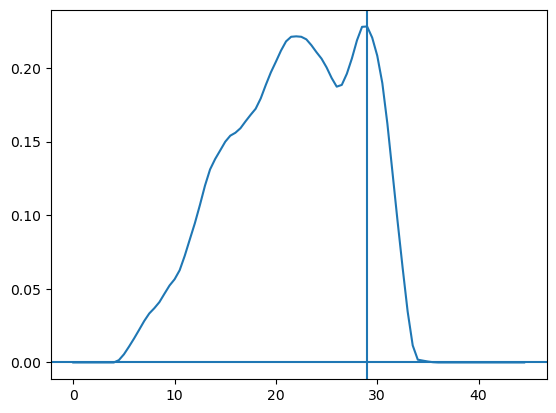

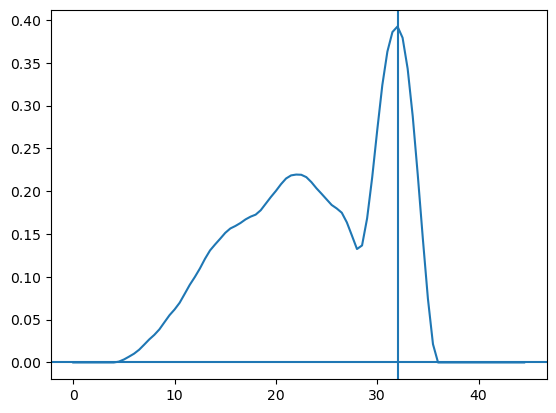

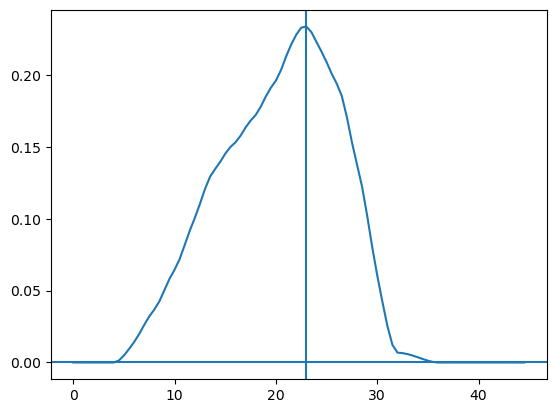

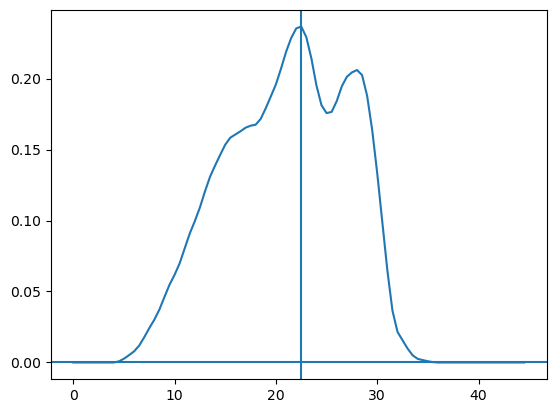

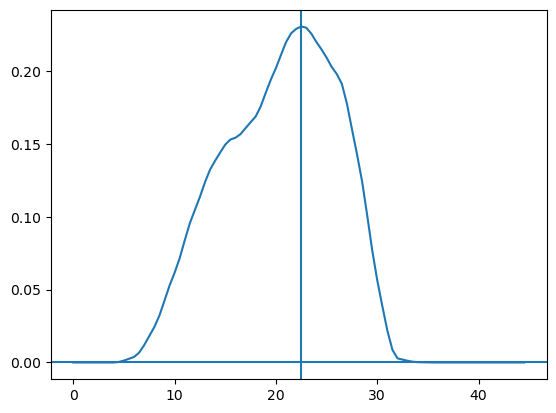

In [16]:
bs = 500
n_channels = 1

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 1  # Example: 5 classes

epochs = 250

model_args = (input_dim, hidden_dim, num_layers, output_dim)
model_class = temp_response_learner

coeffs_list = fit_on_subsets(temp_series_DE, NDVI_labels_DE, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=True, CNN=False)

23.0


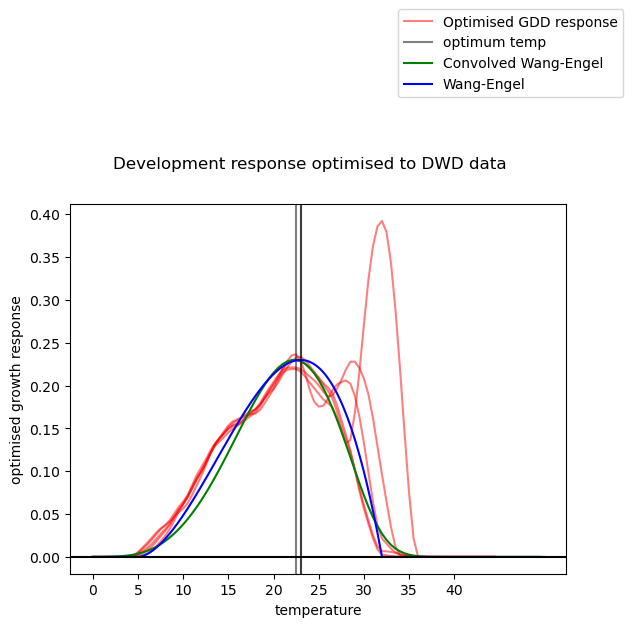

In [92]:
table = vec_expint(7, 23.5, 30, np.arange(0, 50, 0.5), 2.5, 5)
unconvolved = modelling_fctns.Wang_Engel_Temp_response(np.arange(0, 50, 0.1), 5, 23, 32)
def B_0(u):
    return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)
fig, ax = plt.subplots()
for i, co in enumerate(coeffs_list):
    def response(meantemp):
        resp = 0
        for i, coeff in enumerate(co):
            resp += torch.abs(coeff)*B_0(0.25*(meantemp - i*2))
        return resp
    if i == 2:
        ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)), alpha = 0.5, color = 'red', label='Optimised GDD response')
        maxval = np.arange(0, 45, 0.5)[response(np.arange(0, 45, 0.5)).argmax()]
        print(maxval)
        ax.axvline(maxval, alpha = 0.5, color = 'black', label = 'optimum temp')
    else:
        ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)), alpha = 0.5, color = 'red')
    
ax.plot(np.arange(0, 50, 0.5), table*0.23/table.max(), color = 'green', label = 'Convolved Wang-Engel')
maxval = np.arange(0, 50, 0.5)[table.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black')
ax.plot(np.arange(0, 50, 0.1), unconvolved*0.23/unconvolved.max(), color = 'blue', label = 'Wang-Engel')
maxval = np.arange(0, 50, 0.1)[unconvolved.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black')
ax.axhline(0, color = 'black')
ax.set_xlabel('temperature')
ax.set_ylabel('optimised growth response')
ax.set_xticks(np.arange(0, 45, 5))
fig.suptitle('Development response optimised to DWD data')
fig.legend(bbox_to_anchor = (1, 1.3))


In [9]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')
skip = 1
numsteps = int(163 // skip)
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
#photoperiod_series_SSA = torch.Tensor((ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]] > 11).astype(int).values)#12
photoperiod_series_SSA = torch.Tensor(ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]].values)#12
day_series_SSA = torch.Tensor([[skip*n for n in range(numsteps)] for count in range(len(ds_inputs_SSA))])
year_series_SSA = torch.Tensor([ds_inputs_SSA['year'] for count in range(numsteps)]).T
id_series_SSA = torch.Tensor([ds_inputs_SSA['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1) #, photoperiod_series_SSA
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

0 38.876075744628906 38.650489807128906
5 38.33977508544922 38.11037826538086
10 38.30888748168945 38.0819091796875
15 37.76735305786133 37.536720275878906
20 37.7336311340332 37.504188537597656
25 37.643402099609375 36.955448150634766
30 37.146087646484375 36.920841217041016
35 36.59192657470703 36.36382293701172
40 36.545005798339844 36.31973648071289
45 35.98384475708008 35.75715637207031
50 35.414302825927734 35.186492919921875
55 35.34639358520508 34.609954833984375
60 34.76361083984375 34.02791976928711
65 34.110809326171875 33.433250427246094
70 33.065582275390625 32.8304443359375
75 32.44908905029297 32.036075592041016
80 31.298255920410156 31.055068969726562
85 30.12312126159668 29.83152961730957
90 28.75384521484375 28.14210319519043
95 26.69769859313965 26.188701629638672
100 24.281845092773438 23.51629638671875
105 21.038101196289062 19.952390670776367
110 16.17186164855957 14.725687980651855
115 8.919641494750977 6.813098907470703
120 2.011627674102783 1.1141560077667236
1

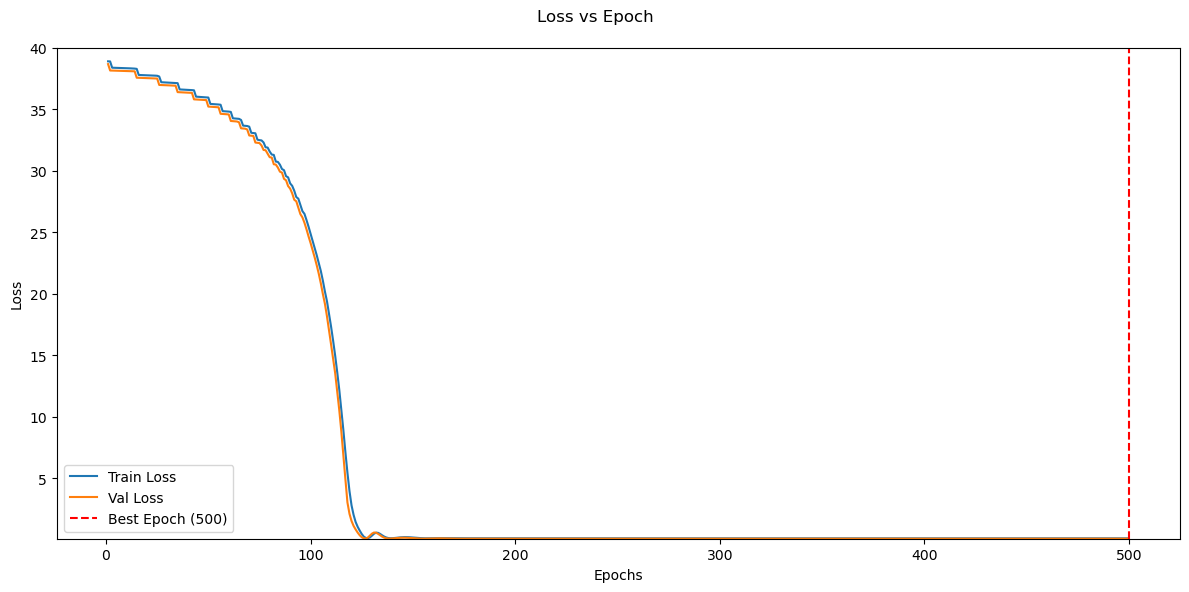

In [85]:
bs = 500
n_channels = 1
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, NDVI_series_DE
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.95)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 32
num_layers = 2
output_dim = 1  # Example: 5 classes


save_name = 'temp_response_wang_SSA'

bce = True
CNN = False

model = temp_response_learner(input_dim, hidden_dim, num_layers, output_dim)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 500
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce)

In [ ]:
epochs = 50
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce)

u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([0.])
u5 tensor([-0.0880])
u6 tensor([0.0054])
u7 tensor([0.0717])
u8 tensor([0.0809])
u9 tensor([0.0691])
u10 tensor([0.0756])
u11 tensor([0.0968])
u12 tensor([0.0902])
u13 tensor([0.1131])
u14 tensor([0.1124])
u15 tensor([0.0840])
u16 tensor([3.6280e-05])
u17 tensor([0.])
u18 tensor([0.])
u19 tensor([0.])
p0 tensor([13.8375])
27.0


Text(0.5, 0.98, 'Development response optimised to SSA data')

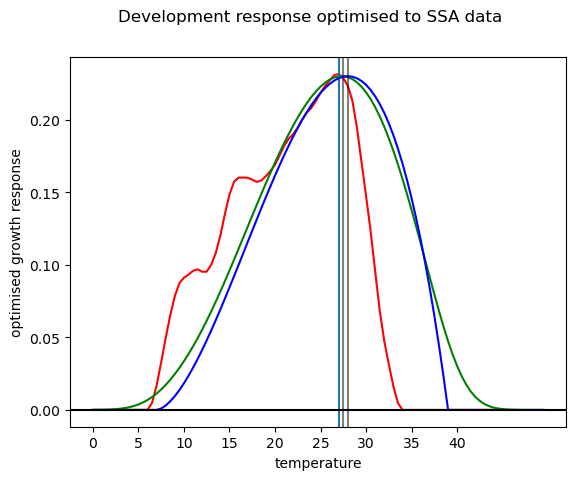

In [88]:
coeffs = []
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        coeffs.append(param.data)
coeffs = coeffs[:-4]

def B_0(u):
    return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)

def response(meantemp):
    resp = 0
    for i, coeff in enumerate(coeffs):
        resp += torch.abs(coeff)*B_0(0.25*(meantemp - i*2))
    return resp
    
fig, ax = plt.subplots()
ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)), color = 'red', label = 'empirical response')
maxval = np.arange(0, 45, 0.5)[response(np.arange(0, 45, 0.5)).argmax()]
print(maxval)
ax.axvline(maxval)
ax.plot(np.arange(0, 50, 0.5), table*0.23/table.max(), color = 'green', label = 'Convolved Wang-Engel')
maxval = np.arange(0, 50, 0.5)[table.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black')
ax.plot(np.arange(0, 50, 0.5), unconvolved*0.23/unconvolved.max(), color = 'blue', label = 'Wang-Engel')
maxval = np.arange(0, 50, 0.5)[unconvolved.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black', label = 'optimum temperature')
ax.axhline(0, color = 'black')
ax.set_xlabel('temperature')
ax.set_ylabel('optimised growth response')
ax.set_xticks(np.arange(0, 45, 5))
fig.suptitle('Development response optimised to SSA data')

In [ ]:
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA)), 0, 1)
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl, method = 'regression', bce=bce, CNN=CNN)#

In [10]:
class nn_temp_response(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, KG=True):
        super(nn_temp_response, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.KG = KG

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False) # batch_first handles input shape (batch, seq, features)
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4= nn.Linear(hidden_dim, hidden_dim)
        self.layer5 = nn.Linear(hidden_dim, hidden_dim)
        self.layer6= nn.Linear(hidden_dim, hidden_dim)
        self.layer7 = nn.Linear(hidden_dim, hidden_dim)
        self.layer8 = nn.Linear(hidden_dim, hidden_dim)
        self.layer9 = nn.Linear(hidden_dim, hidden_dim)
        self.layer10= nn.Linear(hidden_dim, hidden_dim)
        self.layer11 = nn.Linear(hidden_dim, hidden_dim)
        self.layer12 = nn.Linear(hidden_dim, hidden_dim)
        self.layer13= nn.Linear(hidden_dim, hidden_dim)
        self.layer14 = nn.Linear(hidden_dim, hidden_dim)
        self.layer15 = nn.Linear(hidden_dim, hidden_dim)
        self.layer16 = nn.Linear(hidden_dim, hidden_dim)
        self.layer17 = nn.Linear(hidden_dim, hidden_dim)
        self.layer18 = nn.Linear(hidden_dim, hidden_dim)
        self.layers_list = [self.input_layer, self.layer1, self.layer2, self.layer3,
                            self.layer4, self.layer5, self.layer6,
                            self.layer7, self.layer8, self.layer9,
                            self.layer10, self.layer11, self.layer12,
                            self.layer13, self.layer14, self.layer15,
                            self.layer16, self.layer17, self.layer18]
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification
        self.input_dim = input_dim
        self.sig = nn.Sigmoid()

        self.activation = nn.LeakyReLU(negative_slope=0.01)

        self.u0 = torch.nn.Parameter(torch.Tensor([1])) #Now TTR
        self.u1 = torch.nn.Parameter(torch.Tensor([0])) #not used
        self.u2 = torch.nn.Parameter(torch.Tensor([0])) # not used
        self.u3 = torch.nn.Parameter(torch.Tensor([0])) #not used

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        

    def forward(self, x0):
        x = x0[:, :, :4]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Apply Wang Engel
        T_min = 9 + 8*(torch.tanh(self.u1)) - 4 #was 2*
        T_opt = 28 + 8*(torch.tanh(self.u2)) - 4 #was 3*
        T_max = 39 + 2*torch.tanh(self.u3) - 4 #was 1*
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(x.shape)
        #print(T_min, T_opt, T_max)
        #print(alpha)
        #print(((2*(x - T_min)*(x >= T_min))**alpha))
        if self.KG:
            x[:, :, 0] = ( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        #x = torch.nan_to_num(x)
        #x = x*(x >= T_min)*(x<= T_max)
        #print(x)
        #print(x, x.shape)
        # Make cumulative
        if self.input_dim == 3:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        # Forward pass through LSTM
        #x = torch.swapaxes(x, 1, 2)
        #for i, linlayer in enumerate([self.input_layer, self.layer1, self.layer2, self.layer3, 
        #                              self.layer4, self.layer5, self.layer6,
        #                              self.layer7, self.layer8, self.layer9,
        #                              self.layer10, self.layer11, self.layer12]):
        for i, linlayer in enumerate(self.layers_list[:self.num_layers]):
            #print(i)
            #print(x.shape)
            #print(conv)
            x = linlayer(x)
            x = self.activation(x)
            #x = x[:, :, :-conv.padding[0]]
        #torch.nn.init.xavier_uniform(self.fc.weight)
        # Get the hidden state of the last time step
        # output[:, -1, :] is more efficient for batch_first=True
        #last_hidden = output[:, -1, :] # (batch, hidden_dim)
        #print(self.fc(output))
        
        # Classify all layers using fully connected layer
        out_space = self.fc(x) # (batch, output_dim)
        out_space = torch.cumsum(out_space, dim=1) #x[:, :, 0] = self.u0*torch.cumsum(x[:, :, 0], dim = 1)
        if self.output_dim == 1:
            out_scores = self.sig(out_space - self.u0)
        else:
            out_scores = F.log_softmax(out_space, dim=2)

        #print(out_scores.max())
        return out_scores

In [11]:
bs = 250
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 4
output_dim = 1  # Example: 5 classes
bce = True
CNN = False
KG = False

epochs = 2500
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = nn_temp_response

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=bce, CNN=CNN, lr = 0.001)

Fold 1
Loss: 0.1000269278883934
Fold 2


KeyboardInterrupt: 

In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

In [14]:
loss_values_outlier = np.array(loss_values_raw)[[0, 1, 3, 4]]
R2s_outlier = np.array(R2s_raw)[[0, 1, 3, 4]]
Biases_outlier = np.array(Biases_raw)[[0, 1, 3, 4]]
Variances_outlier = np.array(Variances_raw)[[0, 1, 3, 4]]
score = np.mean(loss_values_outlier)
score_stde = np.std(loss_values_outlier)/np.sqrt(5)
R2_score = np.mean(R2s_outlier)
R2_stde = np.std(R2s_outlier)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_outlier)**2)
Bias_stde = np.std(np.array(Biases_outlier)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_outlier)
Variance_stde = np.std(Variances_outlier)/np.sqrt(5)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model ####
loss 0.08158170132949823 +/- 0.0011735902870786945
R2 0.539517268538475 +/- 0.009512910996988278
Bias 1.4095807075500488 +/- 0.4881840389611978
Variance 69.87857913970947 +/- 1.9365423397382626


In [16]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model ####
loss 0.0857873895036034 +/- 0.0017501291191818161
R2 0.5025057911872863 +/- 0.03304838901787813
Bias 5.320456504821777 +/- 2.65924510467014
Variance 65.17378997802734 +/- 2.6935101650037243


In [15]:
bs = 250
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 4
output_dim = 1  # Example: 5 classes
bce = True
CNN = False
KG = False

epochs = 2500
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = nn_temp_response

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=bce, CNN=CNN, lr = 0.001)

Fold 1
Loss: 0.10632183402776718
Fold 2
Loss: 0.10671341419219971
Fold 3
Loss: 0.07519201934337616
Fold 4
Loss: 0.09973899275064468
Fold 5
Loss: 0.09799212962388992


In [16]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model SSA ####
loss 0.1493362158536911 +/- 0.054862736700971436
R2 0.4223050832748413 +/- 0.06124715833323278
Bias 3.0792195796966553 +/- 1.7015497732485039
Variance 74.30063247680664 +/- 10.535685162350985


0 20.72592544555664 19.98701286315918
5 6.2040276527404785 4.771924018859863
10 2.237943410873413 1.8327006101608276
15 1.0651249885559082 0.9992823600769043
20 0.6477017402648926 0.5585809946060181
25 0.43493205308914185 0.4193515181541443
30 0.33043521642684937 0.3862776458263397
35 0.2802301049232483 0.3066577911376953
40 0.24997691810131073 0.30366039276123047
45 0.22778937220573425 0.26461511850357056
50 0.21358555555343628 0.2685061991214752
55 0.20266897976398468 0.24868984520435333
60 0.1942337304353714 0.2546887993812561
65 0.18827594816684723 0.24125586450099945
70 0.18315784633159637 0.24477627873420715
75 0.17867180705070496 0.24181866645812988
80 0.17531755566596985 0.23769798874855042
85 0.17235659062862396 0.23783695697784424
90 0.16949541866779327 0.23568737506866455
95 0.16697438061237335 0.2319856733083725
100 0.1643819659948349 0.22689411044120789
105 0.1608126163482666 0.22250567376613617
110 0.1584896445274353 0.22135339677333832
115 0.15656404197216034 0.221252217

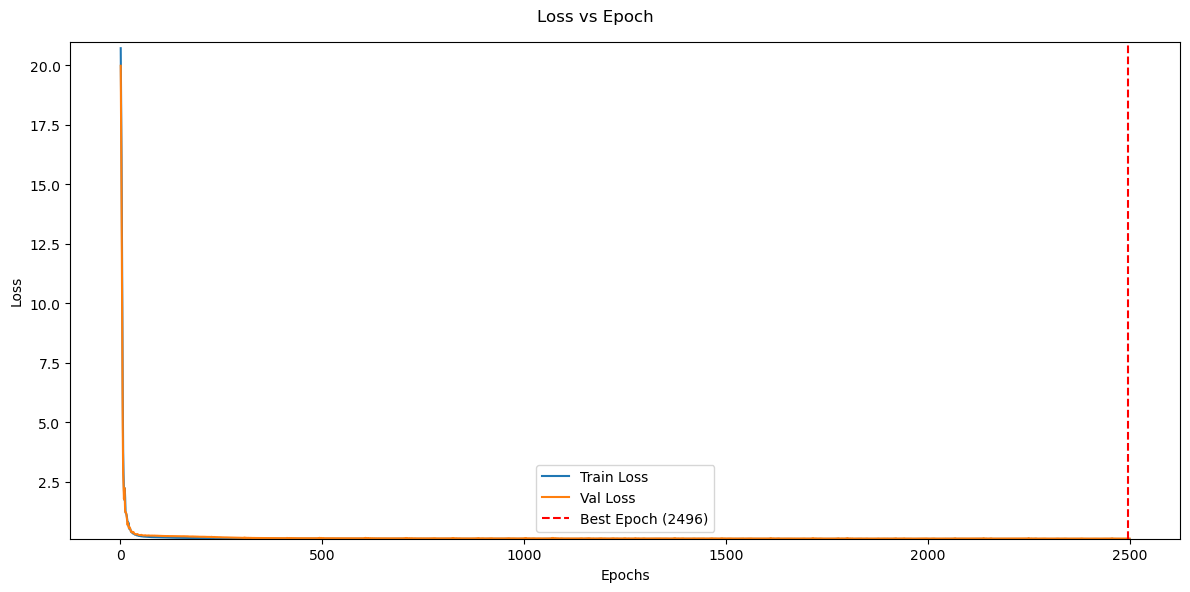

In [38]:
bs = 250
n_channels = 4
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #photoperiod_series_DE,
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.95)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 4
output_dim = 1  # Example: 5 classes

save_name= 'NN_response_SSA'

model = nn_temp_response(input_dim, hidden_dim, num_layers, output_dim)
#for param in [model.u2]: #[model.u1, model.u2, model.u3]:
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() # nn.NLLLoss() # nn.BCELoss() #  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 2500
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

OrderedDict([('u0', tensor([1.1530])), ('u1', tensor([-0.1794])), ('u2', tensor([0.3816])), ('u3', tensor([-0.4020])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[-0.1974, -0.2006, -0.0475,  0.2221],
        [ 0.0257, -0.0198, -0.0496,  0.0122],
        [ 0.1149, -0.2155,  0.1518,  0.1868],
        [-0.1645, -0.1128,  0.0752,  0.1435],
        [-0.2248,  0.2379, -0.0086, -0.0520],
        [-0.1826, -0.0774,  0.1675,  0.1776],
        [ 0.2482,  0.2398,  0.1657, -0.0479],
        [ 0.1480, -0.2085,  0.2146,  0.1298],
        [-0.0570, -0.1773, -0.0914,  0.0834],
        [-0.1016, -0.1098,  0.2369,  0.0051],
        [ 0.0644,  0.1220,  0.2233,  0.2405],
        [ 0.2089, -0.1299,  0.0426,  0.0930],
        [-0.0095,  0.0818, -0.1380,  0.2496],
        [-0.0396, -0.1339,  0.2145, -0.1666],
        [ 0.1908,  0.1698,  0.0816, -0.1312],
        [ 0.2103, -0.0689,  0.0935, -0.1742],
        [-0.0281,  0.1960, -0.1748,  0.0414],
        [-0.1968, -0.1785, -0.1091,  0.2427],
        

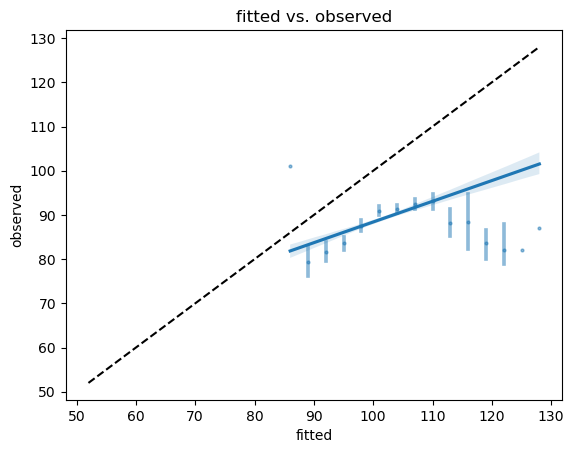

In [41]:
#save_name= 'Simple_NN_KG_SAT_pp'
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl_DE, method = 'regression', bce=bce, CNN=CNN)#

In [15]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
output_dim = 1  # Example: 5 classes

epochs = 100
model_class = nn_temp_response
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)

CNN = False
bce = True

k_folds = 5

for num_layers in [4, 8, 16]:
    for hidden_dim in [4, 8, 16]:
        print(num_layers, 'layers', ' hidden dim', hidden_dim)
        if num_layers == 4 and hidden_dim == 4:
            continue
        CNN_args = (input_dim, hidden_dim, num_layers, output_dim)
        loss_values, R2s, Biases, Variances = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, CNN_args, savename_prefix = 'KFold', loss = 'BCE', CNN=CNN, bce=bce)
        score = np.mean(loss_values)
        score_std = np.std(loss_values)
        R2_score = np.mean(R2s)
        R2_std = np.std(R2s)
        print(f'{num_layers} layers\nhidden dim {hidden_dim}\nloss {score} +/- {score_std}\nR2 {R2_score} +/- {R2_std}')

4 layers  hidden dim 4
4 layers  hidden dim 8
Fold 1
Loss: 0.09616621111788647
Fold 2
Loss: 0.09566244860446822
Fold 3
Loss: 0.09476258567863469
Fold 4
Loss: 0.09438741723520498
Fold 5
Loss: 0.09320732081260687
4 layers
hidden dim 8
loss 0.09493828170281887 +/- 0.002420975512318771
R2 0.37770284414291383 +/- 0.019117042911555693
4 layers  hidden dim 16
Fold 1
Loss: 0.09261867260383762
Fold 2
Loss: 0.09239977217391353
Fold 3
Loss: 0.09415661846640051
Fold 4
Loss: 0.09497429841538102
Fold 5
Loss: 0.09179341441275127
4 layers
hidden dim 16
loss 0.09486407761935563 +/- 0.004295512494431185
R2 0.3825199007987976 +/- 0.03583584992555995
8 layers  hidden dim 4
Fold 1
Loss: 0.0961160135534185
Fold 2
Loss: 0.10060566749309494
Fold 3
Loss: 0.09688205700984269
Fold 4
Loss: 0.09487669004143157
Fold 5
Loss: 0.09302868716818326
8 layers
hidden dim 4
loss 0.09687764126985862 +/- 0.003657330615980168
R2 0.3614853620529175 +/- 0.026865292197698572
8 layers  hidden dim 8
Fold 1
Loss: 0.09523385585723479

KeyboardInterrupt: 

4 layers
hidden dim 8
loss 0.09493828170281887 +/- 0.002420975512318771
R2 0.37770284414291383 +/- 0.019117042911555693

4 layers
hidden dim 16
loss 0.09486407761935563 +/- 0.004295512494431185
R2 0.3825199007987976 +/- 0.03583584992555995

8 layers
hidden dim 4
loss 0.09687764126985862 +/- 0.003657330615980168
R2 0.3614853620529175 +/- 0.026865292197698572

8 layers
hidden dim 8
loss 0.09825641053378115 +/- 0.0018010093072599591
R2 0.34743714332580566 +/- 0.039617697187614036

8 layers
hidden dim 16
loss 0.09622502034269967 +/- 0.0037492410465446847
R2 0.3490405440330505 +/- 0.0566075686691473

4 layers
hidden dim 4
loss 0.09671930811207077 +/- 0.0018048219953200194
R2 0.3694689631462097 +/- 0.017327979076895317

In [42]:
comparison_frame = get_comparison_frame(save_name, model, val_dl_DE, bce=bce, CNN=CNN)

In [43]:
comparison_frame['fitted'] = comparison_frame['fitted'] - comparison_frame['fitted'].mean()
comparison_frame['observed'] = comparison_frame['observed'] - comparison_frame['observed'].mean()

In [44]:
r2_score(comparison_frame['observed'] - comparison_frame['observed'].mean(), comparison_frame['fitted'] - comparison_frame['fitted'].mean()) #

-0.016082406044006348

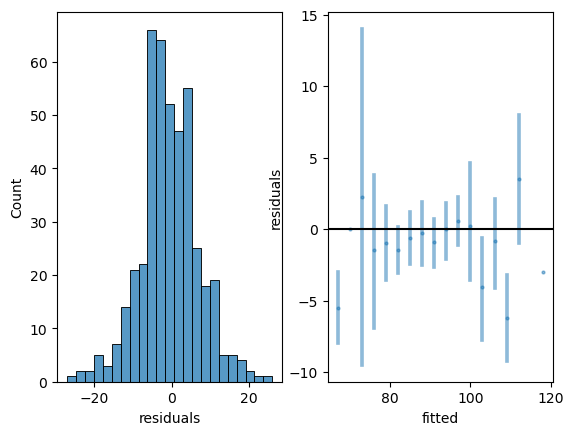

In [44]:
plot_residuals(comparison_frame)

In [43]:
def plot_residuals(comparison_frame):
    fig, axs = plt.subplots(1, 2)
    comparison_frame['residuals'] = comparison_frame['observed'] - comparison_frame['fitted']
    sns.histplot(comparison_frame['residuals'], ax = axs[0])
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['residuals'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['residuals'].min())
    
    sns.regplot(x='fitted', y='residuals', data = comparison_frame, ax=axs[1],
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3),
                fit_reg = False)
    axs[1].axhline(0, color = 'black')

In [ ]:
class simple_nn_Classifier_KG(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(simple_nn_Classifier_KG, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False) # batch_first handles input shape (batch, seq, features)
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4= nn.Linear(hidden_dim, hidden_dim)
        self.layer5 = nn.Linear(hidden_dim, hidden_dim)
        self.layer6= nn.Linear(hidden_dim, hidden_dim)
        self.layer7 = nn.Linear(hidden_dim, hidden_dim)
        self.layer8 = nn.Linear(hidden_dim, hidden_dim)
        self.layer9 = nn.Linear(hidden_dim, hidden_dim)
        self.layer10= nn.Linear(hidden_dim, hidden_dim)
        self.layer11 = nn.Linear(hidden_dim, hidden_dim)
        self.layer12 = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification
        self.input_dim = input_dim
        self.sig = nn.Sigmoid()

        self.activation = nn.LeakyReLU(negative_slope=0.01)

        self.u0 = torch.nn.Parameter(torch.Tensor([1]))
        self.u1 = torch.nn.Parameter(torch.Tensor([0]))
        self.u2 = torch.nn.Parameter(torch.Tensor([0]))
        self.u3 = torch.nn.Parameter(torch.Tensor([0]))

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Apply Wang Engel
        T_min = 9 + 2*(torch.tanh(self.u1))
        T_opt = 28 + 3*(torch.tanh(self.u2))
        T_max = 39 + torch.tanh(self.u3)
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(T_min, T_opt, T_max)
        #print(alpha)
        #print(((2*(x - T_min)*(x >= T_min))**alpha))
        #x[:, :, 0] = ( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        #x = torch.nan_to_num(x)
        #x = x*(x >= T_min)*(x<= T_max)
        #print(x)
        #print(x, x.shape)
        # Make cumulative
        x[:, :, 0] = self.u0*torch.cumsum(x[:, :, 0], dim = 1)
        if self.input_dim == 3:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        # Forward pass through LSTM
        #x = torch.swapaxes(x, 1, 2)
        for i, linlayer in enumerate([self.input_layer, self.layer1, self.layer2, self.layer3, 
                                      self.layer4, self.layer5, self.layer6,
                                      self.layer7, self.layer8, self.layer9,
                                      self.layer10, self.layer11, self.layer12]):
            #print(i)
            #print(x.shape)
            #print(conv)
            x = linlayer(x)
            x = self.activation(x)
            #x = x[:, :, :-conv.padding[0]]
        #torch.nn.init.xavier_uniform(self.fc.weight)
        # Get the hidden state of the last time step
        # output[:, -1, :] is more efficient for batch_first=True
        #last_hidden = output[:, -1, :] # (batch, hidden_dim)
        #print(self.fc(output))
        
        # Classify all layers using fully connected layer
        out_space = self.fc(x) # (batch, output_dim)
        if self.output_dim == 1:
            out_scores = self.sig(out_space)
        else:
            out_scores = F.log_softmax(out_space, dim=2)


        return out_scores

In [ ]:
bs = 250
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

epochs = 50
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim)

model_class = simple_nn_Classifier_KG

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='NLL', bce=False, CNN=False)

Fold 1
Loss: 0.08391246811878504
Fold 2
Loss: 0.08361983797087426
Fold 3
Loss: 0.08282656307082939
Fold 4
Loss: 0.0840181593704131
Fold 5
Loss: 0.08372888977491157


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### simple nn model SSA ####
loss 0.09319833964109421 +/- 0.008512759681746064
R2 0.3604199528694153 +/- 0.07515899247537987


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias = np.mean(Biases_raw)
Variance = np.mean(Variances_raw)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### simple nn model ####
loss 0.0839767403257725 +/- 0.0007066481698857139
R2 0.32629200220108034 +/- 0.00820013488725414


In [ ]:
print(Bias, Variance)

1.3918283516135772 34.686642827690136


OrderedDict([('u0', tensor([0.9372])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('p0', tensor([13.4497])), ('lstm.weight_ih_l0', tensor([[ 1.2259e-01, -1.0271e-02, -1.4785e-01],
        [ 8.1613e-02,  1.2288e-01, -1.1837e-01],
        [-1.1447e-01, -5.7956e-02,  7.2874e-02],
        [-2.6153e-02, -3.6232e-02,  6.4837e-02],
        [-1.5935e-02, -5.5384e-02, -8.1134e-02],
        [ 1.6410e-01,  4.0563e-02,  1.0685e-01],
        [-1.6115e-01,  9.1416e-02,  5.6207e-02],
        [-9.0601e-03, -1.1208e-01, -1.7060e-01],
        [ 1.3888e-01, -1.1498e-01, -1.1597e-01],
        [ 1.1428e-01, -1.1882e-01,  6.1536e-02],
        [-1.0707e-01, -7.9775e-02,  6.9671e-02],
        [ 2.4617e-02, -9.0246e-02, -3.8770e-03],
        [-9.0492e-02,  9.5185e-02,  2.5435e-02],
        [ 1.5126e-01, -8.1294e-02,  1.1947e-01],
        [-1.4448e-01,  1.1778e-01, -1.1594e-01],
        [ 1.2721e-01,  1.2488e-01,  4.7802e-02],
        [ 1.5589e-01, -5.9244e-02, -3.5436e-02],
        [-8.7

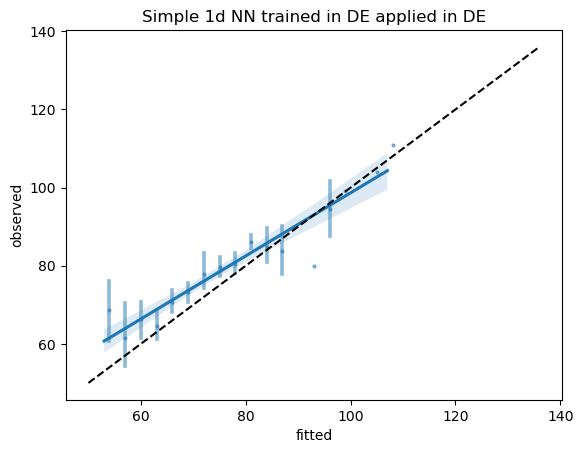

In [ ]:
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA)), 0, 1) #photoperiod_series_SSA, 
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved('Simple_NN_KG_SAT_pp', model, val_dl_SSA, method = 'regression', bce=True, CNN=False, title = 'Simple 1d NN trained in DE applied in DE')#